### I failed to install this package so I change the notebook to not use the package
[limbdark package](https://github.com/john-livingston/limbdark)
$git clone https://github.com/john-livingston/limbdark.git

In [ ]:
#conda create -n XXX python
#!pip install notebook
!pip install numpy   
!pip install scipy   
!pip install pandas   
!pip install matplotlib   
!pip install astropy    
!pip install astroquery   
!pip install aplpy    
!pip install scikit-learn    
!pip install tqdm   
!pip install emcee    
!pip install h5py  
!pip install corner

In [1]:
import os
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
#from pysynphot import spectrum as S
from glob import glob
import itertools
import corner


#import limbdark as ld

import emcee
from emcee.utils import sample_ball
from multiprocessing import Pool


import scipy
import scipy.optimize as op
from scipy.constants import k,c,h
from scipy import integrate
from scipy import stats

from astropy import units as u
from astropy import constants as const
from astropy.constants import G,R_jup,R_sun,M_jup,M_sun,au,pc,sigma_sb, e

# Definition and filter settings

vega mag to AB mag   
http://www.astronomy.ohio-state.edu/~martini/usefuldata.html

In [2]:
def _bb_f(lam,T):
    '''
    Planck's law[W/m**2/Hz/sr] with fixed temperature
    [input]
    temp: star's effective temperature
    '''    
    nu = c/lam
    B_freq = 2*h*nu**3 / (c**2 * (np.exp(h*nu/ (k*T)) - 1))
    
    return B_freq


def _band_intensity(temp, filt):
    '''
    calculate mean intensity
    ref: Bessell(2011) eq.(A12)
    
    [Input]
    temp: effective temperature of the star[K]
    filt: filter profile downloaded from SVO filter profile
    '''
    lam = filt[0] * 1e-10
    bb_freq_med = []
    
    for i in range(len(filt)):
        nu = []
        ar_freq = []
        ar_bb_freq = []
        ar_freq = np.linspace(lam[i]-100e-10, lam[i]+100e-10, 10)
        ar_bb_freq = np.empty(len(ar_freq))
        for j in range(len(ar_freq)):
            ar_bb = []
            ar_bb = _bb_f(ar_freq[j],temp)
        bb_freq_med = np.median(ar_bb)

    nume = math.fsum(bb_freq_med*filt[1]/(c/lam))
    denomi = math.fsum(filt[1]/(c/lam))
    mean_intensity = nume/denomi
    
    return mean_intensity



class Mesh2D:
    def __init__(self, xrange, yrange, n):
        self.n = n
        self.x_min = xrange[0]
        self.x_max = xrange[1]
        self.y_min = yrange[0]
        self.y_max = yrange[1]
        self.x = np.linspace(xrange[0], xrange[1], n)
        self.y = np.linspace(yrange[0], yrange[1], n)
        self.X, self.Y = np.meshgrid(self.x, self.y)
        

def _g_ratio(y, z, us, I_mean, xmin, xmax, ysmin, ysmax, zsmin, zsmax, ratio):
    #mu = cos(theta)
    u1,u2 = us

    mu = np.sqrt(1-(y**2+z**2))
    I_mu = (1 - u1*(1-mu) - u2*(1-mu)**2) * I_mean
    if xmin>0 or xmax>0:
        I_mu[(y>ysmin)&(y<ysmax)&(z>zsmin)&(z<zsmax)] = I_mu[(y>ysmin)&(y<ysmax)&(z>zsmin)&(z<zsmax)] * ratio
    
    I_mu[np.isnan(I_mu)] = 0.
    return I_mu

def _g_ldk(y, z, us, us_spot, I_mean, I_mean_spot, xmin, xmax, ysmin, ysmax, zsmin, zsmax):
    #mu = cos(theta)
    u1,u2 = us
    u1_s, u2_s = us_spot

    mu = np.sqrt(1-(y**2+z**2))
    I_mu = (1 - u1*(1-mu) - u2*(1-mu)**2) * I_mean
    I_mu_spot = (1 - u1_s*(1-mu) - u2_s*(1-mu)**2) * I_mean_spot

    if xmin>0 or xmax>0:
        I_mu[(y>ysmin)&(y<ysmax)&(z>zsmin)&(z<zsmax)] = I_mu_spot[(y>ysmin)&(y<ysmax)&(z>zsmin)&(z<zsmax)]
    
    I_mu[np.isnan(I_mu)] = 0.
    return I_mu


def _ldc(ld_params, band, law='quadratic'):
    '''
    calculate limb-darkening coefficients
    
    [Input]
    ld_params :list of the parameters to calculate LDCs. [teff, uteff, logg, ulogg, feh, ufeh]
    band: filter name (ex. 'V' 'r*')
    '''
    teff, uteff, logg, ulogg, feh, ufeh = ld_params
    ldc_list     = []
    ldc_err_list = []
    ldp = []
    
    ldc = ld.claret(band, teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4), law=law)
    ldp.append(ldc)
    #u1,u2
    ldc_list=[ldc[0],ldc[2]] #take first and third element of ldc 
    #uncertainties
    ldc_err_list=[ldc[1],ldc[3]] #take second and fourth element of ldc
    
    return ldc_list

def u_to_q(u1, u2):
    '''
    convert limb-darkening coefficients
    from u to q
    
    see Eq. 15 & 16 in Kipping 2013
    '''
    q1 = (u1 + u2)**2
    q2 = u1 / (2 * (u1 + u2))
    return q1, q2

def q_to_u(q1, q2):
    '''
    convert limb-darkening coefficients
    from q to u
    
    see Eq. 17 & 18 in Kipping 2013
    '''
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

def _Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, math.cos(theta),-math.sin(theta)],
                   [ 0, math.sin(theta), math.cos(theta)]])
  
def _Ry(theta):
    return np.matrix([[ math.cos(theta), 0, math.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-math.sin(theta), 0, math.cos(theta)]])
  
def _Rz(theta):
    return np.matrix([[ math.cos(theta), -math.sin(theta), 0 ],
                   [ math.sin(theta), math.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

def _Ru(inc, phi):
    ux = math.cos(inc)
    uy = 0
    uz = math.sin(inc)
    
    alpha = 1 - math.cos(phi)
    beta  = math.sin(phi)
    
    return np.matrix([[alpha*ux**2 + math.cos(phi), alpha*ux*uy - beta*uz,      alpha*ux*uz + beta*uy],
                               [alpha*uy*ux + beta*uz,     alpha*uy**2 + math.cos(phi), alpha*uy*uz - beta*ux],
                               [alpha*uz*ux - beta*uy,      alpha*uz*uy + beta*ux,     alpha*uz**2+math.cos(phi)]])



def _lc_ldk_new(params, time, period, dist, ngrid, nrho, filter_name):
    '''
    time            : observed time
    period          : period comes from 
    dist         [m]: distance
    ngrid           : mesh grid
    nrho            : the number of points along the circumference of the spot
    filter_name     : 'V','B' etc..
    
    '''
    phase = []
    r_s,r_spot,Teff,Tspot,inc,lat,lon,q1e,q2e,q1s,q2s = params 
    
    ueff = q_to_u(q1e,q2e)
    uspot = q_to_u(q1s,q2s)
    phi = math.pi/2 - inc
    for i in range(len(time)):
        phase.append(math.modf((time[i] - np.min(time))/period)[0]*2*np.pi)
    #phase = np.arange(0, 2*np.pi, phase_width)
    spot0_pos_ang = np.linspace(0, 2*np.pi, nrho)
    spot_origin = np.array([[1],[0],[0]])
    
    R = _Ry(lat) * _Rz(lon) * _Ry(phi)
    I_mean = _band_intensity(Teff,filt[filter_name])
    I_mean_spot = _band_intensity(Tspot, filt[filter_name])
    
    coord_all = []
    coord_min = []
    coord_max = []
    for i in range(len(phase)):

        ys        = [[] for _ in range(nrho)] 
        zs        = [[] for _ in range(nrho)] 
        spot0   = [[] for _ in range(nrho)] #matrix
        coord0 =  [[] for _ in range(nrho)] #matrix after rotation

        for j in range(nrho):
            x0 = np.sqrt(1 - r_spot**2)
            zs[j] = r_spot * np.sin(spot0_pos_ang[j])
            ys[j] = r_spot * np.cos(spot0_pos_ang[j])

            spot0[j] = np.array([[x0],[ys[j]],[zs[j]]])
            coord0[j] = (_Ru(inc, phase[i]) * (R * spot0[j]))

        coord_all.append(coord0)
        coord_max.append(np.amax(coord_all[i], axis=0))
        coord_min.append(np.amin(coord_all[i], axis=0))
        
        
    Zs = [[] for _ in range(len(phase))] 
    m = Mesh2D([-1,1], [-1, 1], ngrid)
    for i in range(len(phase)):
        Zs[i] = _g_ldk(m.X, m.Y, ueff, uspot, I_mean, I_mean_spot, coord_min[i][0],coord_max[i][0],coord_min[i][1],coord_max[i][1], coord_min[i][2], coord_max[i][2])


    sum_intensity_x = [[] for _ in range(len(phase))] 
    sum_intensity   = [[] for _ in range(len(phase))] 
    test_flux   = [[] for _ in range(len(phase))] 
    spot_mag        = [[] for _ in range(len(phase))] 
    
    test_flux_new  = [[] for _ in range(len(phase))] 
    for i in range(len(Zs)):
        for j in range(len(Zs[i])):
            sum_intensity_x[i].append(math.fsum(Zs[i][j]))
        sum_intensity = math.fsum(sum_intensity_x[i])
        r_d = r_s * R_sun/dist
        #test_flux = np.pi * sum_intensity/(ngrid**2) * 1/2 * (-math.cos(2*math.asin(r_d)) + 1)
        #arcsin's 3rd order Maclaurin expansion
        #arcsin = r_d + 1/6*r_d**3 + 3/40*r_d**5 + 5/112*r_d**7
        test_flux_new = np.pi * sum_intensity/(ngrid**2) * 1/2 * ( 2*(math.sin(math.asin(r_d)))**2)
        #print(test_flux_new)
        
        Av = 0.55
        if filter_name=='R':
            spot_mag[i].append(-2.5 * np.log10(test_flux_new*1e3)- 48.6 + 0.74*Av)
        elif filter_name=='I':
            spot_mag[i].append(-2.5 * np.log10(test_flux_new*1e3)- 48.6 + 0.48*Av)
        elif filter_name=='V':
            spot_mag[i].append(-2.5 * np.log10(test_flux_new*1e3)- 48.6 + Av) 
        else:
            print('please add extinction info in this function')

    spot_mag_flat = list(itertools.chain.from_iterable(spot_mag))
        
    return spot_mag_flat


def obj(param, time, period, dist, ngrid, nrho, filter_name, mag, magerr):
    '''
    objective function: chi-squared
    '''
    mag_model = _lc_ldk_new(param, time, period, dist, ngrid, nrho, filter_name)
    
    return np.sum(((mag-mag_model)/magerr)**2)


def rms(mag,mag_model):
    residual = mag-mag_model
    #return np.sqrt((residual**2).sum()/residual.size)
    
    return np.sqrt(np.mean((residual)**2))


def obj_all(params_full, period, dist, ngrid, nrho, filter_name, df_dict):
    '''
    objective function: chi-squared
    '''
    
    params_each = {}
    
    params_common = params_full[0:7].tolist()
    params_each['I'] = params_common + params_full[7:11].tolist()
    params_each['R'] = params_common + params_full[11:15].tolist()
    params_each['V'] = params_common + params_full[15:19].tolist()
    
    
        
    chi2 = 0
    for b in filter_name:
        data = df_dict[b]
        time_ = data['JD']
        mag_ab_ =  data[b+'_mag_ab']
        umag_ = data[b+'_band_magnitudes_Error']
        mag_model_ = _lc_ldk_new(params_each[b], time_, period, dist, ngrid, nrho, b)
        chisq = np.sum(((mag_ab_- mag_model_)/umag_)**2)
        chi2 += chisq
    
    return chi2


def logprior(full_params, inc_prior=None):
    r_s,r_spot,Teff,Tspot,inc,lat,lon,q1e,q2e,q1s,q2s = full_params
    
    if  (q1e < 0 or q1e > 1) or \
        (q2e < 0 or q2e > 1) or \
        (q1s < 0 or q1s > 1) or \
        (q2s < 0 or q2s > 1) or \
        (inc < 0 or inc > np.pi/2 ) or \
        (lat < -np.pi/2 or lat > np.pi/2) or \
        (lon < -np.pi or lon > np.pi ):
        return -np.inf
    
    lp = 0
    
    if inc_prior is not None:
        inc_mean,inc_err = inc_prior
        lp += np.log(stats.norm.pdf(inc, loc=inc_mean, scale=inc_err))
        
    return lp 


def logprob(full_params, 
                 time_list, 
                 period, 
                 dist, 
                 ngrid, 
                 nrho, 
                 filters, 
                 mag_list, 
                 magerr_list,
                 inc_err=None):
    
    t1,t2,t3          = time_list
    mag1,mag2,mag3    = mag_list
    umag1,umag2,umag3 = magerr_list
    
    r_s,r_spot,Teff,Tspot,inc,lat,lon,\
    q1e_i,q2e_i,q1s_i,q2s_i,\
    q1e_r,q2e_r,q1s_r,q2s_r,\
    q1e_v,q2e_v,q1s_v,q2s_v = full_params
    
    #w0g: offset; w1g: airmass; w2g:dx; w3g:dy
    theta1 = [r_s,r_spot,Teff,Tspot,inc,lat,lon,q1e_i,q2e_i,q1s_i,q2s_i]
    theta2 = [r_s,r_spot,Teff,Tspot,inc,lat,lon,q1e_r,q2e_r,q1s_r,q2s_r]
    theta3 = [r_s,r_spot,Teff,Tspot,inc,lat,lon,q1e_v,q2e_v,q1s_v,q2s_v]
    
    #sum loglike for each band
    ll  = loglike(theta1, t1, period, dist, ngrid, nrho, filters[0], mag1, umag1, inc_prior)
    ll += loglike(theta2, t2, period, dist, ngrid, nrho, filters[1], mag2, umag2, inc_prior)
    ll += loglike(theta3, t3, period, dist, ngrid, nrho, filters[2], mag3, umag3, inc_prior)

    if inc_prior is not None: 
        lp  = logprior(theta1,inc_prior=inc_prior)
        lp += logprior(theta2,inc_prior=inc_prior)
        lp += logprior(theta3,inc_prior=inc_prior)
    else:
        lp  = logprior(theta1)
        lp += logprior(theta2)
        lp += logprior(theta3)
    
    if np.isnan(ll).any():
        print('NaN encountered in loglike')
        return -np.inf
    
    #total: sum of prior and likelihood
    return lp + ll



#negative log prob
nlp = lambda *x: -logprob(*x)
    
    
def loglike(params_full, time, period, dist, ngrid, nrho, filter_name, mag, magerr, inc_prior=None):
    '''
    * computes the log likelihood given the optimized transit and model parameters
    * either or both transit and systematics models can also be returned
    '''
    
    #assert err is not a single number
    m = _lc_ldk_new(params_full, time, period, dist, ngrid, nrho, filter_name)
    
    resid = mag - m
    assert magerr.any() != 0

    N = len(resid)
    
    if inc_prior is not None:
        inc_mean, inc_err = inc_prior
        incp = (inc-inc_mean)/inc_err
        
    return -0.5*(N*np.log(2*np.pi) + 2*np.sum(np.log(magerr)) + np.sum((resid/magerr)**2)) + np.sum(incp**2)

['./Generic_Johnson.I.dat', './Generic_Johnson.R.dat', './Generic_Johnson.V.dat']


Text(0.5, 0, 'wavelength[m]')

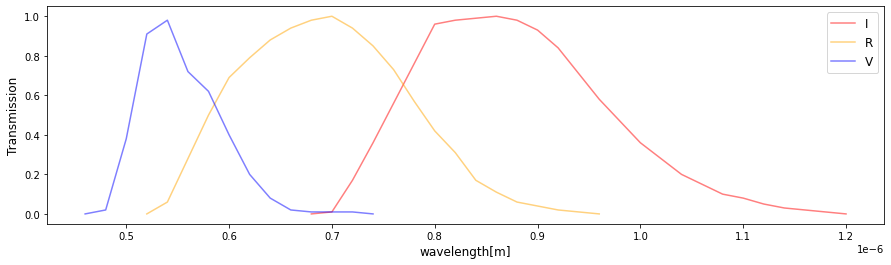

In [3]:
datadir = '.'
path    = os.path.join(datadir,'*.dat')
file_list = glob(path)
file_list = sorted(file_list)
print(file_list)

#DoB
filt={}
bands = 'I,R,V'.split(',')
for fname,b in zip(file_list,bands):
    df=pd.read_table(fname, delimiter=' ', parse_dates=True, header=None)
    #df = df.drop('Unnamed: 0',axis=1)
    #df = df.set_index('GJD-2450000')
    filt[b] = df
filt.keys()

lam_col =  'lambda'
trans_col  =  'transmission'

colors='r,orange,b'.split(',')
fig,ax = plt.subplots(1,1,figsize=(15,4))

n=0
for b,co in zip(bands,colors):
    df = filt[b]    
    lam_nm = df[0]*1e-10
    trans = df[1]
    
    ax.plot(lam_nm, trans, label=b, color=co, alpha=0.5)
    ax.set_ylabel('Transmission', fontsize=12)
    n+=1
plt.legend(loc='upper right',fontsize=12)
plt.xlabel('wavelength[m]',fontsize=12)

In [5]:
_Params_eff = [3779, 90, 3.9849, 0.1, -0.14, 0.16]
_Params_spot = [3000, 90, 3.9849, 0.1, -0.14, 0.16]

'''
_Ldc_eff = []
_Ldc_spot = []

for b,i in zip(bands,range(len(bands))):
    _Ldc_eff.append(_ldc(_Params_eff,b))
    _Ldc_spot.append(_ldc(_Params_spot,b ))

'''

_Ldc_eff = [[0.42742538999999996, 0.23325018],
 [0.59371454, 0.1494387],
 [0.6724234899999999, 0.11397314000000001]]

_Ldc_spot = [[0.34065133, 0.34360536],
 [0.48412123, 0.27845412999999997],
 [0.52225693, 0.2897199]]


#free
_R_s = 1.2262 #R_sun #From DIANA: 1.2262
_R_spot = 0.6 #R_star #From DIANA
_Teff = 3779
_Tspot = 3000
_Inc = math.radians(35.2) #From DIANA/ Kudo-san's paper
_Lat = -1.38
_P = 7.367 #day
_Lon = 0.48

#prior
inc_prior=(math.radians(35.2), math.radians(0.7))

#fix
_D = 144.048*pc #from GAIA
_Nrho = 20
_Ngrid = 300

#full_params =  [r_s,r_spot,Teff,Tspot,inc,lat,lon,q1e_i,q2e_i,q1s_i,q2s_i,q1e_r,q2e_r,q1s_r,q2s_r,q1e_v,q2e_v,q1s_v,q2s_v]
full_params0 = [_R_s,_R_spot,_Teff,_Tspot,_Inc,_Lat,_Lon]
for i in range(len(bands)):
    full_params0.append(u_to_q(_Ldc_eff[i][0],_Ldc_eff[i][1])[0])
    full_params0.append(u_to_q(_Ldc_eff[i][0],_Ldc_eff[i][1])[1])
    full_params0.append(u_to_q(_Ldc_spot[i][0],_Ldc_spot[i][1])[0])
    full_params0.append(u_to_q(_Ldc_spot[i][0],_Ldc_spot[i][1])[1])
    
full_params_array = np.array(full_params0)

# Data

In [6]:
pd.options.display.float_format = '{:.5f}'.format
#DoD
df_phot = pd.read_table('photometry.txt', sep='     ')
df_phot = df_phot[df_phot['JD']<2458527]

dfs    = {}
ts     = {}
mags   = {}
umags  = {}
mag_abs = {}
for b in bands:
    dfs[b] = df_phot[df_phot[b+'_band_counts']!=0]
    dfs[b] = dfs[b].reset_index(drop=True)

    ts[b]    = dfs[b]['JD']
    mags[b]  = dfs[b][b + '_band_magnitudes']
    umags[b] = dfs[b][b + '_band_magnitudes_Error']
    if b == 'I':
        dfs[b][b+'_mag_ab'] = dfs[b][b + '_band_magnitudes'] + 0.45
    elif b == 'V':
        dfs[b][b+'_mag_ab'] = dfs[b][b + '_band_magnitudes'] + 0.02
    elif b == 'R':
        dfs[b][b+'_mag_ab'] = dfs[b][b + '_band_magnitudes'] + 0.21


/home/yterada/anaconda3/envs/test/lib/python3.10/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


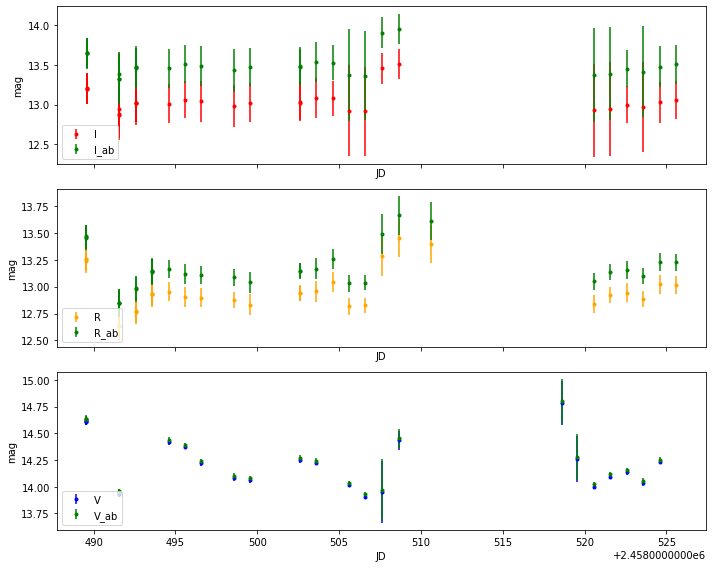

In [7]:
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(10,8), sharex=True)

n=0

for b,co in zip(bands,colors):
    
    data = dfs[b]
    
    _time = data['JD']
    _mag =  data[b+'_band_magnitudes']
    _umag = data[b+'_band_magnitudes_Error']
    _mag_ab = data[b+'_mag_ab']
    
    #plot with specific label (for legend) and color
    ax[n].errorbar(_time, _mag, yerr=_umag, label=b, color=co, fmt='.')
    ax[n].errorbar(_time, _mag_ab, yerr=_umag, label=b+'_ab', color='green', fmt='.')
    
    #add plot labels
    ax[n].set_xlabel('JD')
    ax[n].set_ylabel('mag')
    ax[n].legend(loc='lower left')
    
    #increase the axis counter
    n=n+1
    
#make better spacing
fig.tight_layout()

# EMCEE setting *run only one time

In [8]:
params_each_after = {}
params_common0= full_params0[0:7]
r_s,r_spot,Teff,Tspot,inc,lat,lon,q1e_i,q2e_i,q1s_i,q2s_i = params_common0 + full_params0[7:11]
_,_,_,_,_,_,_,q1e_r,q2e_r,q1s_r,q2s_r = params_common0 + full_params0[11:15]
_,_,_,_,_,_,_,q1e_v,q2e_v,q1s_v,q2s_v = params_common0 + full_params0[15:19]

times    = []
mags   = []
magerrs     = []

#bands2 = 'I,R'.split(',')

for b in bands:
    #sys mod params
    df = dfs[b]
    times.append(df['JD'])
    #mags.append(df[b+'_band_magnitudes'])
    mags.append(df[b+'_mag_ab'])
    magerrs.append(df[b+'_band_magnitudes_Error']) 
    
    
    
full_params = [r_s,r_spot,Teff,Tspot,inc,lat,lon,\
              q1e_i,q2e_i,q1s_i,q2s_i,\
              q1e_r,q2e_r,q1s_r,q2s_r,\
              q1e_v,q2e_v,q1s_v,q2s_v]

param_names='r_s,r_spot,Teff,Tspot,inc,lat,lon,q1e_i,q2e_i,q1s_i,q2s_i,q1e_r,q2e_r,q1s_r,q2s_r,q1e_v,q2e_v,q1s_v,q2s_v'.split(',')

logprob(full_params,times,_P,_D,_Ngrid,_Nrho,bands,mags,magerrs,inc_prior)

/tmp/ipykernel_13407/1802055155.py:73: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1-(y**2+z**2))


-15884.24985885089

In [9]:
nwalkers = 100
ndim = len(full_params)
p0=sample_ball(full_params,std=[1e-2]*ndim,size=nwalkers)

#Set up backend
filename = "test_emcee_grid300_inc-gp_noopt.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, args=(times,_P,_D,_Ngrid,_Nrho,bands,mags,magerrs,inc_prior), pool=pool, backend=backend)


    for p in tqdm(sampler.sample(p0,iterations=50000)):
        pass

0it [00:00, ?it/s]/tmp/ipykernel_13407/1802055155.py:73: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1-(y**2+z**2))
/tmp/ipykernel_13407/1802055155.py:73: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1-(y**2+z**2))
/tmp/ipykernel_13407/1802055155.py:73: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1-(y**2+z**2))
/tmp/ipykernel_13407/1802055155.py:73: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1-(y**2+z**2))
/tmp/ipykernel_13407/1802055155.py:73: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1-(y**2+z**2))
/tmp/ipykernel_13407/1802055155.py:73: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1-(y**2+z**2))
/tmp/ipykernel_13407/1802055155.py:73: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1-(y**2+z**2))
/tmp/ipykernel_13407/1802055155.py:73: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1-(y**2+z**2))
9it [00:33,  3.62s/it]/tmp/ipy

Text(0.5, 0, 'nsteps')

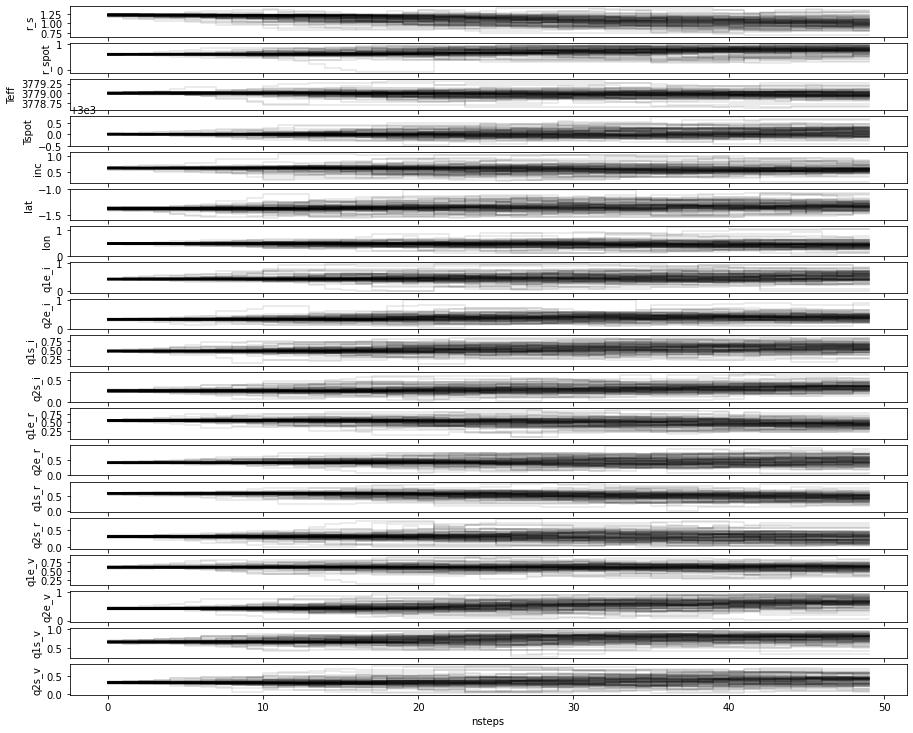

In [10]:
chain = sampler.chain

nsteps, nwalkers, ndim = chain.shape
fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=0.1) for i,c in enumerate(chain.T)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
plt.xlabel('nsteps')

# check EMCEE result

params_each_after = {}
params_common0= full_params0[0:7]
r_s,r_spot,Teff,Tspot,inc,lat,lon,q1e_i,q2e_i,q1s_i,q2s_i = params_common0 + full_params0[7:11]
_,_,_,_,_,_,_,q1e_r,q2e_r,q1s_r,q2s_r = params_common0 + full_params0[11:15]
_,_,_,_,_,_,_,q1e_v,q2e_v,q1s_v,q2s_v = params_common0 + full_params0[15:19]

times    = []
mags   = []
magerrs     = []

#bands2 = 'I,R'.split(',')

for b in bands:
    #sys mod params
    df = dfs[b]
    times.append(df['JD'])
    #mags.append(df[b+'_band_magnitudes'])
    mags.append(df[b+'_mag_ab'])
    magerrs.append(df[b+'_band_magnitudes_Error']) 
    
    
    
full_params = [r_s,r_spot,Teff,Tspot,inc,lat,lon,\
              q1e_i,q2e_i,q1s_i,q2s_i,\
              q1e_r,q2e_r,q1s_r,q2s_r,\
              q1e_v,q2e_v,q1s_v,q2s_v]

param_names='r_s,r_spot,Teff,Tspot,inc,lat,lon,q1e_i,q2e_i,q1s_i,q2s_i,q1e_r,q2e_r,q1s_r,q2s_r,q1e_v,q2e_v,q1s_v,q2s_v'.split(',')

logprob(full_params,times,_P,_D,_Ngrid,_Nrho,bands,mags,magerrs,inc_prior)

nwalkers = 100
ndim = len(full_params)

nwalkers = 100
ndim = len(full_params)

filename = "test_emcee_gp_211203_grid200_inc-prior.h5"
new_backend = emcee.backends.HDFBackend(filename)
print("Initial size: {0}".format(new_backend.iteration))
new_sampler = emcee.EnsembleSampler(
    nwalkers, ndim, logprob, backend=new_backend)

chain = new_sampler.chain

nsteps, nwalkers, ndim = chain.shape
fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=0.1) for i,c in enumerate(chain.T)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
plt.xlabel('nsteps')

#remove chain
chain2=chain[:,35000:40000,:]

nsteps, nwalkers, ndim = chain2.shape
fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=0.1) for i,c in enumerate(chain2.T)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
plt.xlabel('nsteps')

flatchain=chain2.reshape((-1,ndim))
fig2=corner.corner(flatchain, labels=param_names, 
                  quantiles=[0.16, 0.5, 0.84], 
                  smooth = True,
                  show_titles=True, title_kwargs={"fontsize": 12});

meds = []
for i in range(len(param_names)):
    meds.append(np.percentile(chain2[:,:,i].flatten(), [50]))

meds_flat = list(itertools.chain.from_iterable(meds))
meds_flat

params_each_mcmc = {}
params_common_mcmc = meds_flat[0:7]
params_each_mcmc['I'] = params_common_mcmc + meds_flat[7:11]
params_each_mcmc['R'] = params_common_mcmc + meds_flat[11:15]
params_each_mcmc['V'] = params_common_mcmc + meds_flat[15:19]

mag_all_mcmc = {} 
n=0
for b in tqdm(bands):
    data = dfs[b]
    time_ = data['JD']
    #mag_ =  data[b+'_band_magnitudes']
    mag_ab_         = data[b+'_mag_ab']
    umag_ = data[b+'_band_magnitudes_Error']


    m_after_mcmc = _lc_ldk_new(params_each_mcmc[b], time_, _P, _D, _Ngrid, _Nrho, b)
    #print(m_after_)

    dfs[b]['model_mcmc'] = m_after_mcmc
    rms_after_mcmc = rms(mag_ab_, m_after_mcmc)
    print('rms after: {:.4f}'.format(rms_after_mcmc))
   
    #dict of optimized transit parameters to be used later
    mag_all_mcmc[b] = m_after_mcmc

    n+=1

fig,ax = plt.subplots(3,1,figsize=(10,8), sharex=True)
n=0
for b,co in zip(bands,colors):
    print(b)
    data = dfs[b]

    time_              = data['JD']
    #mag_ =  data[b+'_band_magnitudes']
    mag_ab_         = data[b+'_mag_ab']
    umag_            = data[b+'_band_magnitudes_Error']
    model_mcmc_ = data['model_mcmc']

    #plot flux raw data
    ax[n].errorbar(time_, mag_ab_, yerr=umag_, 
                    label='data', alpha=0.5, color=co) 

    ax[n].plot(time_, model_mcmc_, 'k-', lw=3, label='mcmc')
    ax[n].set_title('{}-band'.format(b), fontsize=12)
    ax[n].legend(fontsize=10)
    ax[n].set_ylabel('Magnitude', fontsize=12)
    n+=1
    
#plt.savefig('plot_emcee_rspot-0.6_tspot-2800.png')

# all data overplot

pd.options.display.float_format = '{:.5f}'.format
df_all = pd.read_table('photometry.txt', sep='     ')

dfs_all    = {}
ts_all     = {}
mags_all   = {}
umags_all  = {}
#mag_abs_all = {}

for b in bands:
    dfs_all[b] = df_all[df_all[b+'_band_counts']!=0]
    dfs_all[b] = dfs_all[b].reset_index(drop=True)

    ts_all[b]    = dfs_all[b]['JD']
    mags_all[b]  = dfs_all[b][b + '_band_magnitudes']
    umags_all[b] = dfs_all[b][b + '_band_magnitudes_Error']
    if b == 'I':
        dfs_all[b][b+'_mag_ab'] = dfs_all[b][b + '_band_magnitudes'] + 0.45
    elif b == 'V':
        dfs_all[b][b+'_mag_ab'] = dfs_all[b][b + '_band_magnitudes'] + 0.02
    elif b == 'R':
        dfs_all[b][b+'_mag_ab'] = dfs_all[b][b + '_band_magnitudes'] + 0.21
        
        
m_mag_all = {} 
n=0
for b in tqdm(bands):
    t_model_fit = np.arange(2458488,2458768,0.2)

    m_after_fit = _lc_ldk_new(params_each_mcmc[b], t_model_fit, _P, _D, _Ngrid, _Nrho, b)
    m_mag_all[b] = m_after_fit

    n+=1

fig,ax = plt.subplots(3,1,figsize=(10,8), sharex=True)
n=0
for b,co in zip(bands,colors):
    print(b)
    data = dfs_all[b]

    time_              = data['JD']
    #mag_ =  data[b+'_band_magnitudes']
    mag_ab_         = data[b+'_mag_ab']
    umag_            = data[b+'_band_magnitudes_Error']

    #plot flux raw data
    ax[n].errorbar(time_, mag_ab_, yerr=umag_, 
                    label='data', alpha=0.8, color=co) 

    ax[n].plot(t_model_fit, m_mag_all[b], 'k-', lw=3, label='mcmc')
    ax[n].set_title('{}-band'.format(b), fontsize=12)
    ax[n].legend(fontsize=10)
    ax[n].set_ylabel('Magnitude', fontsize=12)
    ax[n].set_xlim(2458488,2458527)
    n+=1
#plt.savefig('mag_model_overplot_former.png')

fig,ax = plt.subplots(3,1,figsize=(10,8), sharex=True)
n=0
for b,co in zip(bands,colors):
    print(b)
    data = dfs_all[b]

    time_              = data['JD']
    #mag_ =  data[b+'_band_magnitudes']
    mag_ab_         = data[b+'_mag_ab']
    umag_            = data[b+'_band_magnitudes_Error']

    #plot flux raw data
    ax[n].errorbar(time_, mag_ab_, yerr=umag_, 
                    label='data', alpha=0.5, color=co) 

    ax[n].plot(t_model_fit, m_mag_all[b], 'k-', lw=3, label='mcmc')
    ax[n].set_title('{}-band'.format(b), fontsize=12)
    ax[n].legend(fontsize=10)
    ax[n].set_ylabel('Magnitude', fontsize=12)
    ax[n].set_xlim(2458722,2458768)
    n+=1
    
#plt.savefig('mag_model_overplot_latter.png')

dataset = pd.DataFrame({'time': t_model_fit, 'model_I': list(m_mag_all['I']),'model_R': list(m_mag_all['R']),'model_V': list(m_mag_all['V'])}, columns=['time', 'model_I', 'model_R', 'model_V'])
dataset['model_I_vega'] = dataset['model_I'] - 0.45
dataset['model_R_vega'] = dataset['model_R'] - 0.21
dataset['model_V_vega'] = dataset['model_V'] - 0.02

dataset.to_csv('model_mag_gp.csv')